In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [3]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_095', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [4]:
z=14
n_clusters = 2000
#labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/final_9_cluster_labels_2000.npy'
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file) #z,t
cluster_model_labels = cluster_model_labels[z,:]

In [5]:
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z) #<---------- !!!
brain = np.array(nib.load(brain_file).get_data(), copy=True)

In [92]:
class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        ### Y and Z ###
        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object
            
            ### Interpolate to neural data
            self.fictrac[short] = []
            self.fictrac[short + '_pos'] = []
            self.fictrac[short + '_neg'] = []
            for z in range(49):
                ### Velocity ###
                low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
                self.fictrac[short].append(low_res_behavior/np.std(low_res_behavior))

                ### Clipped Velocities ###
                self.fictrac[short + '_pos'].append(np.clip(self.fictrac[short][-1], a_min=0, a_max=None))
                self.fictrac[short + '_neg'].append(np.clip(self.fictrac[short][-1], a_min=None, a_max=0)*-1)
            
            ### Repeat for a shift
            shift = -300
            self.fictrac[short + '_s'] = []
            self.fictrac[short + '_pos_s'] = []
            self.fictrac[short + '_neg_s'] = []
            for z in range(49):
                ### Velocity ###
                low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z]+shift)
                self.fictrac[short + '_s'].append(low_res_behavior/np.std(low_res_behavior))

                ### Clipped Velocities ###
                self.fictrac[short + '_pos_s'].append(np.clip(self.fictrac[short + '_s'][-1], a_min=0, a_max=None))
                self.fictrac[short + '_neg_s'].append(np.clip(self.fictrac[short + '_s'][-1], a_min=None, a_max=0)*-1)
        
        ### Walking ###
        self.fictrac['walking'] = []
        for z in range(49):    
            YZ = np.sqrt(np.power(self.fictrac['Y'][z],2), np.power(self.fictrac['Z'][z],2))        
            self.fictrac['walking'].append(np.zeros(3384))
            self.fictrac['walking'][-1][np.where(YZ>.2)] = 1
            
        self.fictrac['walking_s'] = []
        for z in range(49):    
            YZ = np.sqrt(np.power(self.fictrac['Y_s'][z],2), np.power(self.fictrac['Z_s'][z],2))        
            self.fictrac['walking_s'].append(np.zeros(3384))
            self.fictrac['walking_s'][-1][np.where(YZ>.2)] = 1

In [93]:
class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [94]:
flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac()
    flies[fly].load_brain_slice()
    flies[fly].load_z_depth_correction()
    flies[fly].get_cluster_averages(cluster_model_labels, n_clusters)


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 9.73 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.02 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 5.63 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.00 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 5.59 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.03 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 112.80 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.83 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.82 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.91 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 5.54 ms


In [56]:
scores_all = []

scores_walking = []
scores_ypos = []
scores_zpos = []
scores_zneg = []

scores_walking_unique = []
scores_ypos_unique = []
scores_zpos_unique = []
scores_zneg_unique = []

t0 = time.time()
for cluster_num in range(n_clusters):
#for cluster_num in [1000]:
    if cluster_num%100 == 0:
        print(cluster_num)
        print(time.time()-t0)
        t0 = time.time()
    ###############################################################
    ### Build Y vector for a single supervoxel (with all flies) ###
    ###############################################################
    #t0 = time.time()
    all_fly_neural = []
    for fly in fly_names:
        signal = flies[fly].cluster_signals[cluster_num,:]
        all_fly_neural.extend(signal)
    Y = np.asarray(all_fly_neural)
    #print(F'Y time {time.time()-t0}')

    ###########################################
    ### Build the X matrix for this cluster ###
    ###########################################
    # For each fly, this cluster could have originally come from a different z-depth
    # Get correct original z-depth
    #t0 = time.time()
    ypos = []
    zpos = []
    zneg = []
    walking = []
    for i, fly in enumerate(fly_names):
        cluster_indicies = flies[fly].cluster_indicies[cluster_num]
        z_map = flies[fly].z_correction[:,:,z].ravel()
        original_z = int(np.median(z_map[cluster_indicies]))
        #flies[fly].fictrac.interp_fictrac(original_z)
        ypos.extend(flies[fly].fictrac.fictrac['Y_pos'][original_z])
        zpos.extend(flies[fly].fictrac.fictrac['Z_pos'][original_z])
        zneg.extend(flies[fly].fictrac.fictrac['Z_neg'][original_z])
        walking.extend(flies[fly].fictrac.fictrac['walking'][original_z])
    #print(F'X time {time.time()-t0}')

    #t0 = time.time()
    ### ALL ###
    X = np.stack((ypos, zpos, zneg, walking)).T
    model = RidgeCV().fit(X,Y)
    scores_all.append(np.sqrt(model.score(X,Y)))
       
    ### Singles ###
    X = np.reshape(walking, (-1, 1))
    model = RidgeCV().fit(X,Y)
    scores_walking.append(np.sqrt(model.score(X,Y)))
    
    X = np.reshape(ypos, (-1, 1))
    model = RidgeCV().fit(X,Y)
    scores_ypos.append(np.sqrt(model.score(X,Y)))
    
    X = np.reshape(zpos, (-1, 1))
    model = RidgeCV().fit(X,Y)
    scores_zpos.append(np.sqrt(model.score(X,Y)))
    
    X = np.reshape(zneg, (-1, 1))
    model = RidgeCV().fit(X,Y)
    scores_zneg.append(np.sqrt(model.score(X,Y)))
        
    ### LOO ###
    X = np.stack((ypos, zpos, zneg)).T
    model = RidgeCV().fit(X,Y)
    scores_walking_unique.append(np.sqrt(model.score(X,Y)))
    
    X = np.stack((zpos, zneg, walking)).T
    model = RidgeCV().fit(X,Y)
    scores_ypos_unique.append(np.sqrt(model.score(X,Y)))
    
    X = np.stack((ypos, zneg, walking)).T
    model = RidgeCV().fit(X,Y)
    scores_zpos_unique.append(np.sqrt(model.score(X,Y)))
    
    X = np.stack((ypos, zpos, walking)).T
    model = RidgeCV().fit(X,Y)
    scores_zneg_unique.append(np.sqrt(model.score(X,Y)))
    #print(F'model time {time.time()-t0}')


0
0.0006513595581054688
100
11.786543607711792
200
11.852516651153564
300
11.804701328277588
400
11.788140296936035
500
11.862927436828613
600
11.797976016998291
700
11.800318002700806
800
11.869041919708252
900
11.80585789680481
1000
11.877573013305664
1100
11.795766353607178
1200
11.8067626953125
1300
11.84352731704712
1400
11.798450946807861
1500
12.148192405700684
1600
11.85968828201294
1700
11.881569623947144
1800
11.839820623397827
1900
11.84946060180664


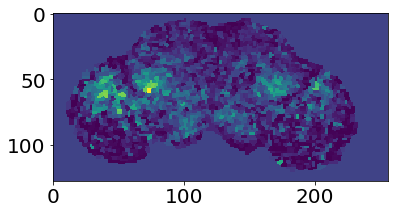

In [57]:


colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_walking_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T)

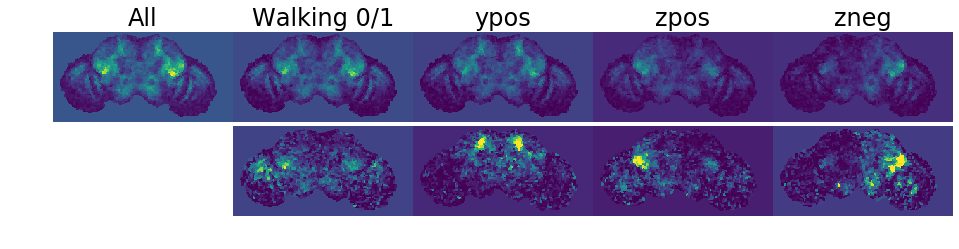

In [58]:
fig = plt.figure(figsize=(10,10))
cmap = 'viridis'
vmin=0
vmax=.2

ax = fig.add_axes([0,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num]# - scores_ypos_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('All')

###############
### SINGLES ###
###############

ax = fig.add_axes([.25,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_walking[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('Walking 0/1')

ax = fig.add_axes([.5,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_ypos[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('ypos')

ax = fig.add_axes([.75,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_zpos[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('zpos')

ax = fig.add_axes([1,0,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_zneg[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')
ax.set_title('zneg')

##############
### UNIQUE ###
##############
vmin=0
vmax=.02

ax = fig.add_axes([.25,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_walking_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([.5,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_ypos_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([.75,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_zpos_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([1,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_zneg_unique[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [95]:
scores_all = []

scores_walking = []
scores_ypos = []
scores_zpos = []
scores_zneg = []

t0 = time.time()
for cluster_num in range(n_clusters):
    if cluster_num%100 == 0:
        print(cluster_num)
        print(time.time()-t0)
        t0 = time.time()
    ###############################################################
    ### Build Y vector for a single supervoxel (with all flies) ###
    ###############################################################
    all_fly_neural = []
    for fly in fly_names:
        signal = flies[fly].cluster_signals[cluster_num,:]
        all_fly_neural.extend(signal)
    Y = np.asarray(all_fly_neural)

    ###########################################
    ### Build the X matrix for this cluster ###
    ###########################################
    # For each fly, this cluster could have originally come from a different z-depth
    # Get correct original z-depth
    ypos = []
    zpos = []
    zneg = []
    walking = []
    
    ypos_s = []
    zpos_s = []
    zneg_s = []
    walking_s = []
    for i, fly in enumerate(fly_names):
        cluster_indicies = flies[fly].cluster_indicies[cluster_num]
        z_map = flies[fly].z_correction[:,:,z].ravel()
        original_z = int(np.median(z_map[cluster_indicies]))
        ypos.extend(flies[fly].fictrac.fictrac['Y_pos'][original_z])
        zpos.extend(flies[fly].fictrac.fictrac['Z_pos'][original_z])
        zneg.extend(flies[fly].fictrac.fictrac['Z_neg'][original_z])
        walking.extend(flies[fly].fictrac.fictrac['walking'][original_z])
        
        ### Additional Time-Shift ###
        ypos_s.extend(flies[fly].fictrac.fictrac['Y_pos_s'][original_z])
        zpos_s.extend(flies[fly].fictrac.fictrac['Z_pos_s'][original_z])
        zneg_s.extend(flies[fly].fictrac.fictrac['Z_neg_s'][original_z])
        walking_s.extend(flies[fly].fictrac.fictrac['walking_s'][original_z])

                                   
    ### ALL ###
    X = np.stack((ypos, zpos, zneg, walking)).T
    model = RidgeCV().fit(X,Y)
    scores_all.append(np.sqrt(model.score(X,Y)))
    
    ### Additional Time-Shift ###
    X = np.stack((ypos, zpos, zneg, walking, ypos_s)).T
    model = RidgeCV().fit(X,Y)
    scores_ypos.append(np.sqrt(model.score(X,Y)))
    
    X = np.stack((ypos, zpos, zneg, walking, zpos_s)).T
    model = RidgeCV().fit(X,Y)
    scores_zpos.append(np.sqrt(model.score(X,Y)))
    
    X = np.stack((ypos, zpos, zneg, walking, zneg_s)).T
    model = RidgeCV().fit(X,Y)
    scores_zneg.append(np.sqrt(model.score(X,Y)))
    
    X = np.stack((ypos, zpos, zneg, walking, walking_s)).T
    model = RidgeCV().fit(X,Y)
    scores_walking.append(np.sqrt(model.score(X,Y)))

0
0.0006928443908691406
100
12.64697790145874
200
12.640779256820679
300
12.707576036453247
400
12.630058288574219
500
12.667757749557495
600
12.66972279548645
700
12.673654556274414
800
12.661707878112793
900
12.630113124847412
1000
12.704513549804688
1100
12.680429935455322
1200
12.68079423904419
1300
12.660751104354858
1400
12.630356788635254
1500
12.710620403289795
1600
12.645195960998535
1700
12.704722166061401
1800
12.646445751190186
1900
12.686269521713257


In [107]:
12*20/60

# one slice with one timeshift takes 4min
# full brain with one shift will take 4*49 = 3hr

4*49

196

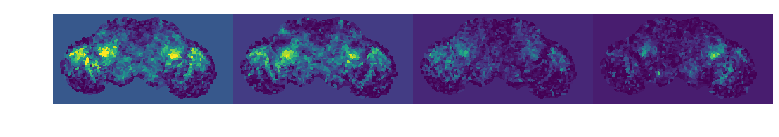

In [100]:
##############
### Shifts ###
##############
fig = plt.figure(figsize=(10,10))
vmin=0
vmax=.03

ax = fig.add_axes([.25,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] =  scores_walking[cluster_num] - scores_all[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([.5,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_ypos[cluster_num] - scores_all[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([.75,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_zpos[cluster_num] - scores_all[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([1,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_zneg[cluster_num] - scores_all[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

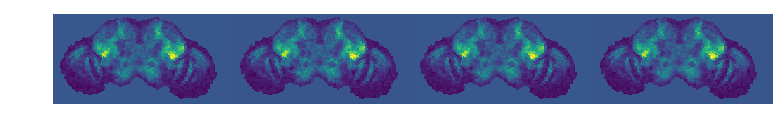

In [90]:
##############
### Shifts ###
##############
fig = plt.figure(figsize=(10,10))
vmin=0
vmax=.2

ax = fig.add_axes([.25,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] =  scores_walking[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([.5,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_ypos[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([.75,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_zpos[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

ax = fig.add_axes([1,-.13,.25,.25])
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_zneg[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)
ax.imshow(colored_by_betas.T,cmap=cmap,vmin=vmin,vmax=vmax)
ax.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')